In [1]:
import numpy as np
import pandas as pd
import os, sys
import glob
import tensorflow as tf
from tensorflow import keras
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt
## Imports: Keras Models
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.models import Sequential, Model
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import random
from sklearn.model_selection import train_test_split
from keras import metrics
### Imports: data preprocessing 
import csv
import numpy as np
import os
import sklearn
import keras.backend as K

sf = 250.
# Path for category 1
young_task_path = "/home/birdfly/Data/task/task young/"
# Path for category 2
young_non_task_path = "/home/birdfly/Data/task/non task young/"

freq_from = 0
freq_to = 20

channels_count = 26

Using TensorFlow backend.


In [2]:
def read_directory(young_task_path, young_non_task_path):
    # task_datas = []
    X_train = []
    y_train = []
    for sub_path in os.listdir(young_task_path):
        task_data_files_paths = glob.glob(os.path.join(young_task_path, sub_path) + "/*.csv")
        for task_data_files_path in task_data_files_paths:
            data = pd.read_csv(task_data_files_path, sep=',')
            data_req = transfer_time_to_freq(data)
            X_train.append(data_req)
            y_train.append(0)

    for sub_path in os.listdir(young_non_task_path):
        task_data_files_paths = glob.glob(os.path.join(young_non_task_path, sub_path) + "/*.csv")
        for task_data_files_path in task_data_files_paths:
            data = pd.read_csv(task_data_files_path, sep=',')
            data_req = transfer_time_to_freq(data)
            X_train.append(data_req)
            y_train.append(1)
            
    X_train = np.asarray(X_train)
    y_train = tf.keras.utils.to_categorical(y=y_train, num_classes=2)
    
    return X_train, y_train

In [3]:
def transfer_time_to_freq(data, freq_from = freq_from, freq_to = freq_to):
    freq_data = []
    for row_index in data:  
        fft_y=fft(data[row_index])
        T = 1/250.  # sampling interval 
        N = data[row_index].size
        # 1/T = frequency
        f = np.linspace(0, 1 / T, N)
        freq_data_row = np.abs(fft_y)[:N // 2] * 1 / N
        freq_data.extend(freq_data_row[freq_from:freq_to])
    
    freq_data_t = pd.DataFrame(freq_data).T.values.tolist()
    return freq_data

In [4]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

In [5]:
def run_model(x_train, y_train, x_test, y_test):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense((freq_to - freq_from)*channels_count, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(max(freq_to - freq_from,channels_count), activation='relu'), 
        tf.keras.layers.Dense(min(freq_to - freq_from,channels_count), activation='relu'),     
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy',f1_score, precision, recall])
    history = model.fit(x_train, y_train, epochs= 50)
    results = model.evaluate(x_test, y_test)
    print('test loss, test acc:', results)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    model.save('model.h5')
    print('model.h5 has been saved.')

Train on 98151 samples
Epoch 1/50
98151/98151 [==============================] - 5s 54us/sample - loss: 0.2154 - accuracy: 0.6671 - f1_score: 0.6436 - precision: 1.0000 - recall: 0.4798
Epoch 2/50
98151/98151 [==============================] - 5s 48us/sample - loss: 0.1626 - accuracy: 0.7611 - f1_score: 0.6660 - precision: 1.0000 - recall: 0.4993
Epoch 3/50
98151/98151 [==============================] - 5s 49us/sample - loss: 0.1419 - accuracy: 0.7942 - f1_score: 0.6670 - precision: 1.0000 - recall: 0.5004
Epoch 4/50
98151/98151 [==============================] - 5s 49us/sample - loss: 0.1277 - accuracy: 0.8190 - f1_score: 0.6670 - precision: 1.0000 - recall: 0.5005
Epoch 5/50
98151/98151 [==============================] - 5s 50us/sample - loss: 0.1178 - accuracy: 0.8344 - f1_score: 0.6670 - precision: 1.0000 - recall: 0.5004
Epoch 6/50
98151/98151 [==============================] - 5s 49us/sample - loss: 0.1093 - accuracy: 0.8479 - f1_score: 0.6673 - precision: 1.0000 - recall: 0.5008

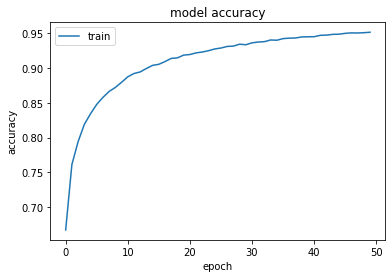

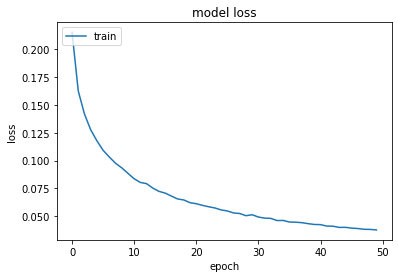

model.h5 has been saved.


In [6]:
if __name__ == "__main__":
    x, y = read_directory(young_task_path, young_non_task_path)
    
    x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

    run_model(x_train, y_train, x_test, y_test)

Train on 98151 samples
Epoch 1/10
98151/98151 [==============================] - 5s 46us/sample - loss: 0.1922 - accuracy: 0.7124 - f1_score: 0.6679 - precision: 1.0000 - recall: 0.5025
Epoch 2/10
98151/98151 [==============================] - 4s 42us/sample - loss: 0.1399 - accuracy: 0.8003 - f1_score: 0.6659 - precision: 1.0000 - recall: 0.4992
Epoch 3/10
98151/98151 [==============================] - 4s 44us/sample - loss: 0.1181 - accuracy: 0.8352 - f1_score: 0.6668 - precision: 1.0000 - recall: 0.5001
Epoch 4/10
98151/98151 [==============================] - 4s 43us/sample - loss: 0.1022 - accuracy: 0.8587 - f1_score: 0.6669 - precision: 1.0000 - recall: 0.5002
Epoch 5/10
98151/98151 [==============================] - 4s 41us/sample - loss: 0.0914 - accuracy: 0.8765 - f1_score: 0.6664 - precision: 1.0000 - recall: 0.4997
Epoch 6/10
98151/98151 [==============================] - 4s 41us/sample - loss: 0.0827 - accuracy: 0.8896 - f1_score: 0.6670 - precision: 1.0000 - recall: 0.5004

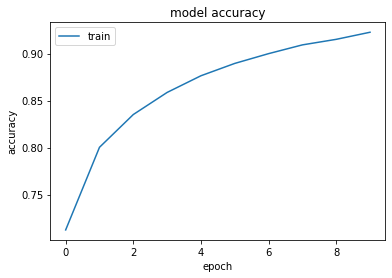

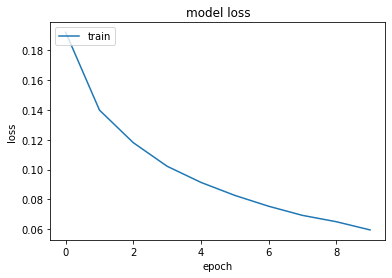

model.h5 has been saved.


In [29]:
run_model(x_train, y_train, x_test, y_test)

In [17]:
print(history.history.keys())

NameError: name 'history' is not defined